# Using code from John to generate some data for test

In [1]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x


# import numpy as np
# import pandas as pd


# def gen_dummy_DO(length, delta=10.0, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, sigma=0.05):
#     """
#     Generate dummy time series data for demonstration purposes.

#     Args:
#     length (int): Length of the time series data.
#     delta (float): Time step.
#     t0 (float): Starting time.
#     dt (float): Duration of the transition.
#     dy (float): Amplitude of the transition.
#     GS_slope (float): Slope of the Gaussian-shaped transition.
#     GIS_slope (float): Slope of the Glacial-interglacial-shaped transition.
#     causal_strength (float): Strength of the causal link.
#     sigma (float): Standard deviation of the noise.
#     tau (float): Time constant for the autoregressive process.

#     Returns:
#     pandas.DataFrame: DataFrame containing dummy time series data.
#     """
#     alpha = np.exp(-delta / tau)
#     # time = np.arange(t0, t0 + length * delta, step=delta, dtype='float')
#     time = np.arange(length, step=delta, dtype='float')
#     trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
#     noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
#     synt_trans = trans + noise

#     df = pd.DataFrame({
#         'time': time,
#         'A': synt_trans,
#         'trans': trans
#     })

#     return df

# def gen_linked_data(df, lag=10, causal_strength=0.5, delta=10.0, tau=1.0, sigma=0.05):
#     """
#     Generate causally linked synthetic data.

#     Args:
#     df (pandas.DataFrame): DataFrame containing synthetic time series data.
#     lag (int): Lag for the causal effect. Positive lag means left shifting the series.
#     causal_strength (float): Strength of the causal link.
#     delta (float): Time step.
#     tau (float): Time constant for the autoregressive process.
#     sigma (float): Standard deviation of the noise.


#     Returns:
#     pandas.DataFrame: DataFrame containing causally linked synthetic data.
#     """
#     synt_trans = df['trans'].values
#     alpha = np.exp(-delta / tau)
#     # Shift the series
#     if lag > 0:
#         left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
#         left_shifted_synt_trans[:-lag] = synt_trans[lag:]
#     if lag < 0:
#         left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
#         left_shifted_synt_trans[-lag:] = synt_trans[:lag]
#     if lag == 0:
#         left_shifted_synt_trans=synt_trans

#     # Generate AR(1) noise as the base for the second causally linked dataset
#     new_noise = sample_ar1(len(synt_trans), alpha=alpha, sigma=sigma, x0=0)

#     # Combine the lagged original series with the new AR(1) series to produce the causally linked series
#     causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

#     df['B'] = causally_linked_synt_trans
#     return df.dropna()






In [25]:
import numpy as np
import pandas as pd

def gen_bi_directional_data(length, delta=10.0, lag=10, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, beta=0.3, sigma=0.05):
    """
    Generate time series data demonstrating bi-directional causality.
    
    Args:
    length (int): Length of the time series data.
    delta (float): Time step.
    sigma (float): Standard deviation of the noise.
    alpha, beta, gamma, (float): Coefficients describing the interaction between the series.

    Returns:
    pandas.DataFrame: DataFrame containing bi-directionally linked synthetic data.

    """
    # let lag must be nagative integer
    if lag > 0:
        raise ValueError('Lag must be a negative integer.')


    time = np.arange(length, step=delta, dtype='float')
    A = np.zeros(len(time))
    B = np.zeros(len(time))

    A[0] = np.random.normal(0, sigma)
    B[0] = np.random.normal(0, sigma)

    alpha = np.exp(-delta / tau)
    
    for t in range(1, len(time)+lag):
        A[t] = alpha * A[t-1] + beta * B[t+lag] + np.random.normal(0, sigma)
        B[t] = alpha * B[t-1] + beta * A[t+lag] + np.random.normal(0, sigma)

    
    trans_A = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)

    # trans_B = linear_ramp(time, t0=t0-lag*10, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
    trans_B = trans_A


    A=trans_A+A
    B=trans_B+B
    
    df = pd.DataFrame({
        'time': time,
        'A': A,
        'B': B
    })
    
    # drop nan values
    df = df.dropna()

    return df


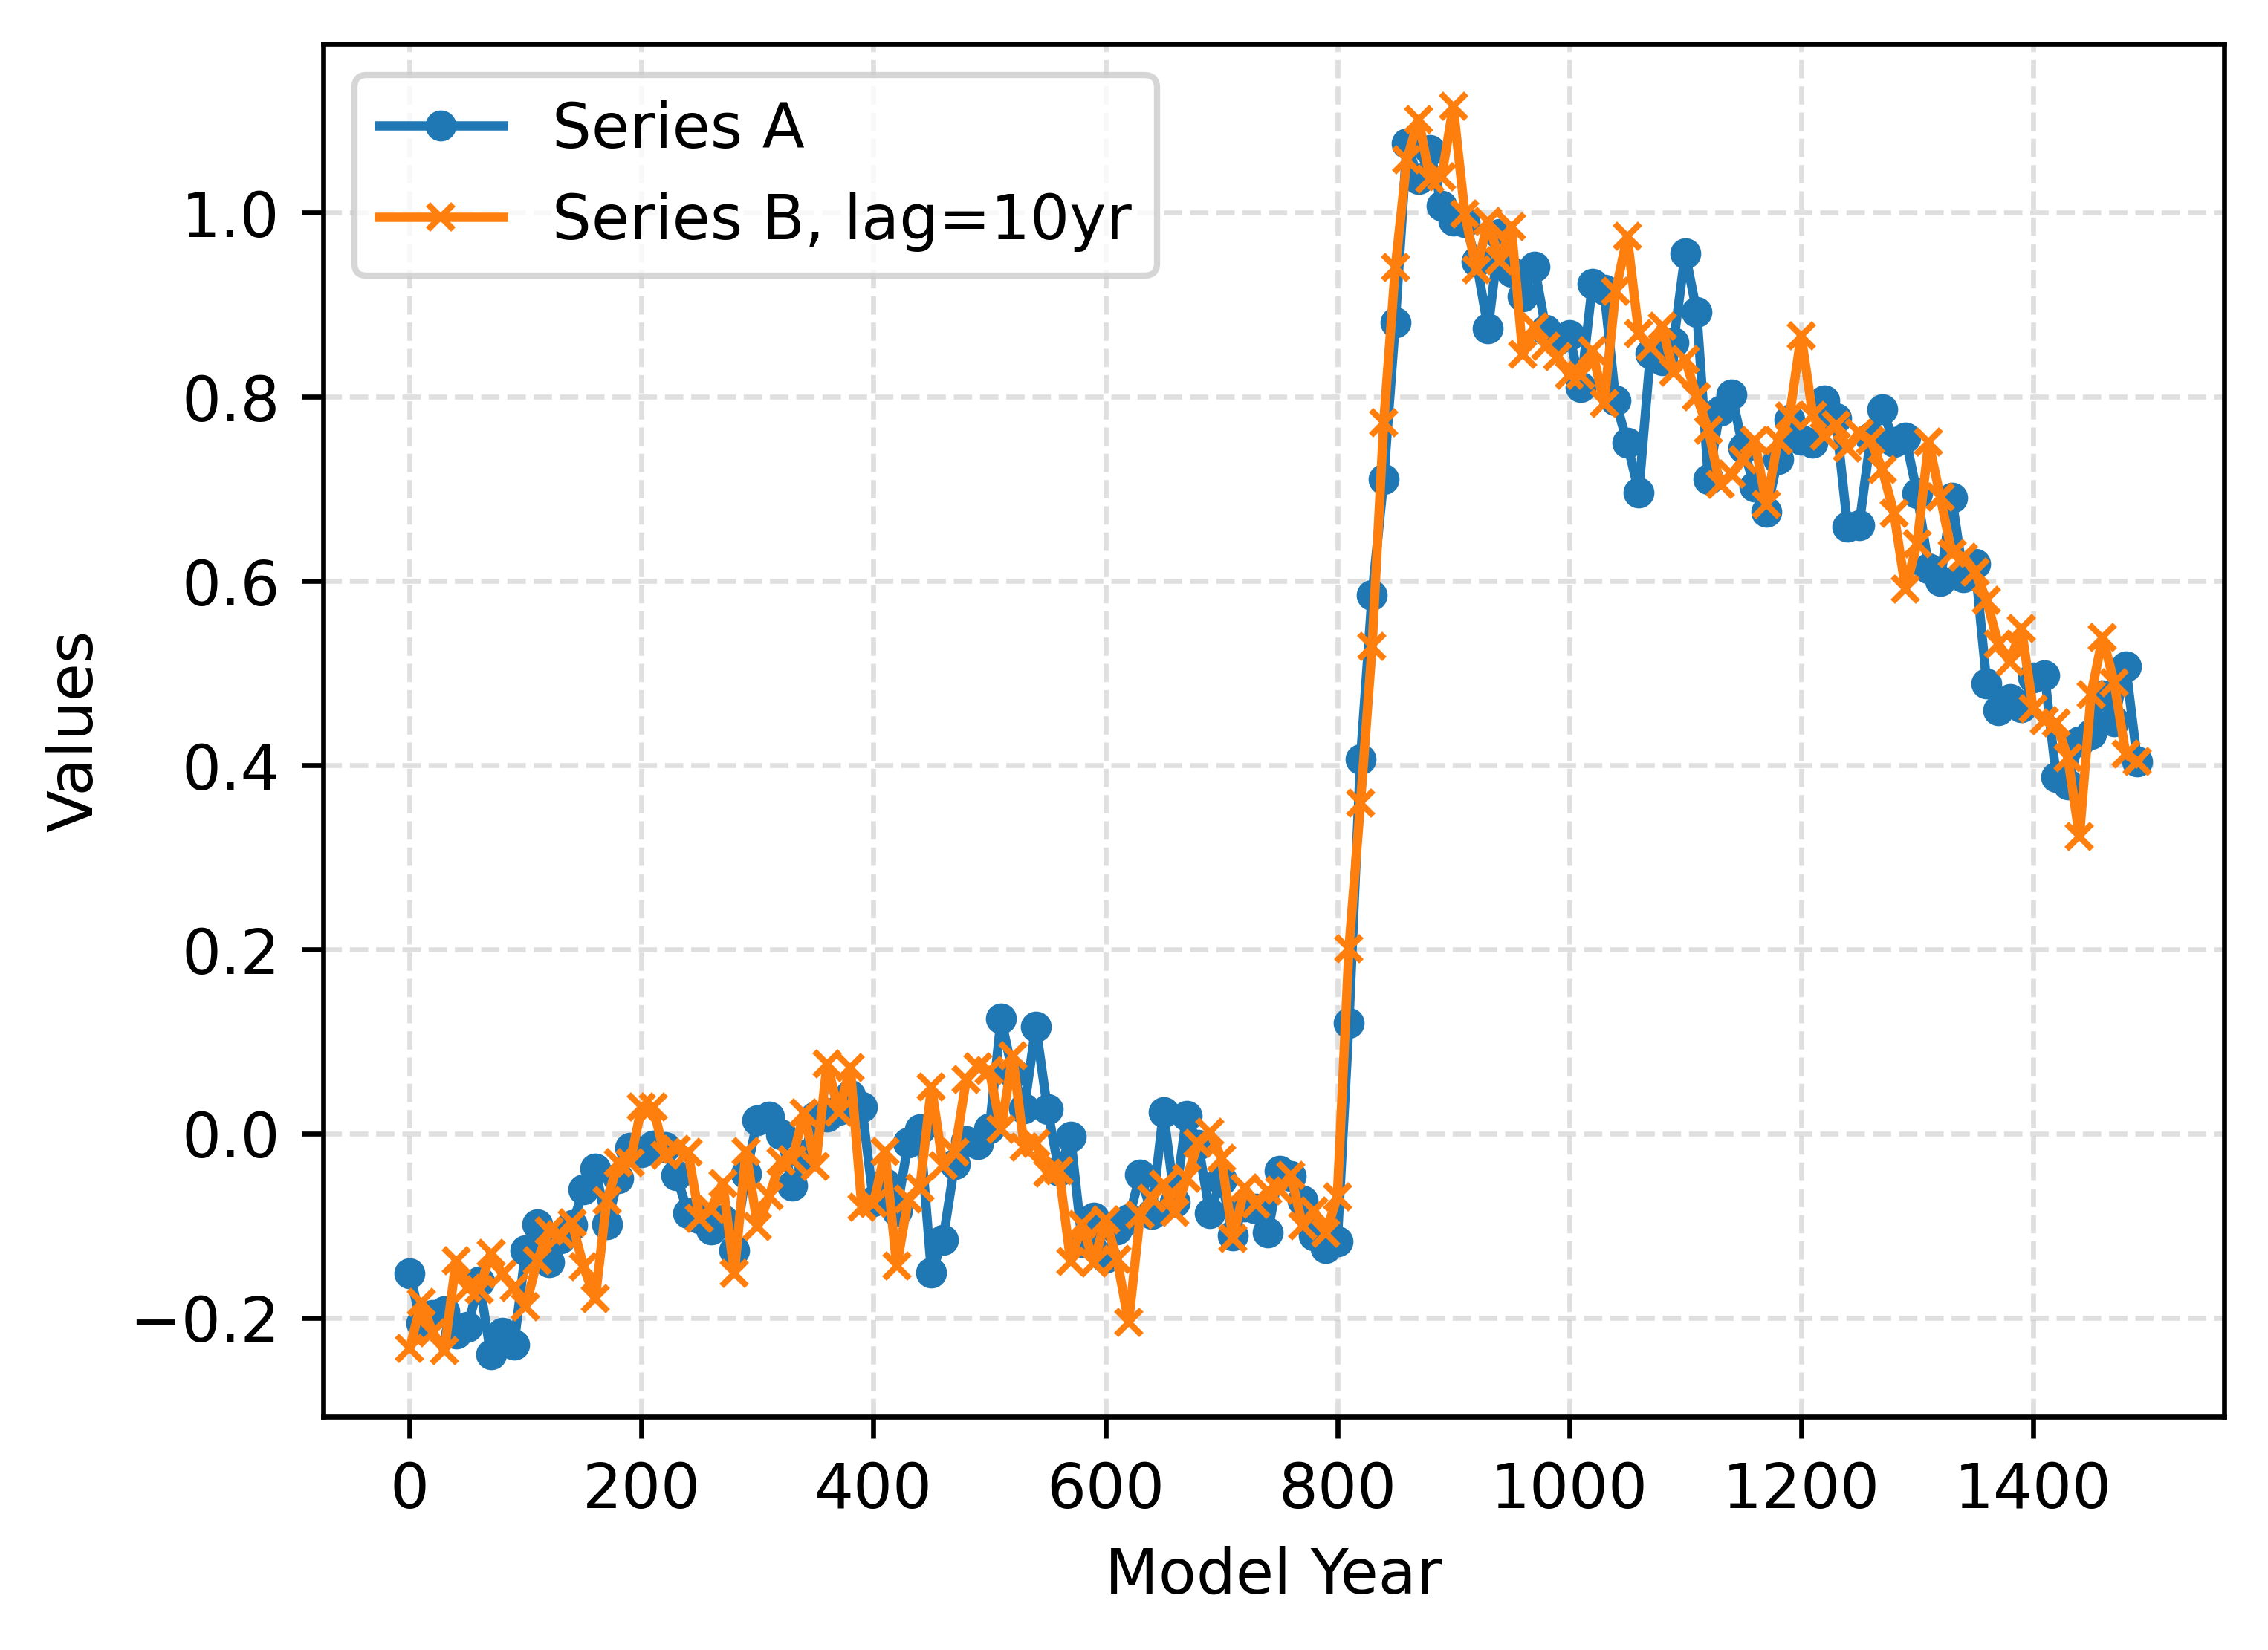

In [29]:
import matplotlib.pyplot as plt

lag=-1
# data = gen_bi_directional_data(length=1500, delta=10, lag=lag, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=13.649751415738818, beta=0.3, sigma=0.05)
data = gen_bi_directional_data(length=1500, delta=10.0, lag=lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=0.3, sigma=0.05)
# data = gen_bi_directional_data(length=1500, delta=10.0, lag=-3, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=0.3, gamma=0.3, sigma=0.05)


# Enhance the plot
plt.figure(figsize=(5.5, 4),dpi=600)  # Adjust the figure size
plt.plot(data['time'], data['A'], label='Series A', linestyle='-', marker='o', markersize=4)
plt.plot(data['time'], data['B'], label=f'Series B, lag={lag*-10}yr', linestyle='-', marker='x', markersize=4)

# Add grid, title, and labels
plt.grid(True, linestyle='--', alpha=0.4)
# plt.title('Time Series of Dummy Warming Data')
plt.xlabel('Model Year')
plt.ylabel('Values')

# Add legend
plt.legend()

plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests,kpss

# grangercausalitytests(dummy_warming_lagged[['A', 'B']], 5, verbose=True)
grangercausalitytests(data[['B', 'A']], 5, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.7445 , p=0.0001  , df_denom=146, df_num=1
ssr based chi2 test:   chi2=17.0885 , p=0.0000  , df=1
likelihood ratio test: chi2=16.1776 , p=0.0001  , df=1
parameter F test:         F=16.7445 , p=0.0001  , df_denom=146, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.0547  , p=0.0002  , df_denom=143, df_num=2
ssr based chi2 test:   chi2=18.7427 , p=0.0001  , df=2
likelihood ratio test: chi2=17.6475 , p=0.0001  , df=2
parameter F test:         F=9.0547  , p=0.0002  , df_denom=143, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.8294  , p=0.0001  , df_denom=140, df_num=3
ssr based chi2 test:   chi2=24.6626 , p=0.0000  , df=3
likelihood ratio test: chi2=22.7994 , p=0.0000  , df=3
parameter F test:         F=7.8294  , p=0.0001  , df_denom=140, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.6425  , p=0.0000  

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (16.744473964891455, 7.046937197328292e-05, 146.0, 1),
   'ssr_chi2test': (17.088538498416625, 3.567696612853181e-05, 1),
   'lrtest': (16.177630995996196, 5.767112629915679e-05, 1),
   'params_ftest': (16.744473964891366, 7.04693719732856e-05, 146.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.054746313354023, 0.00019831971383217986, 143.0, 2),
   'ssr_chi2test': (18.74269166959994, 8.512874206612776e-05, 2),
   'lrtest': (17.647458136410478, 0.00014719842253439142, 2),
   'params_ftest': (9.054746313354043, 0.00019831971383217634, 143.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.82938279741939, 7.21325586637639e-05, 140.0, 3),
   'ssr_chi2test': (24.66255581187108, 1.816345518278895e-05, 3),
   'lrtest': (22.799417495870102, 4.4463160997959055e-05, 3),
   'params_ftest': (7.829382797419341, 7.213255866376848e-05, 140.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0

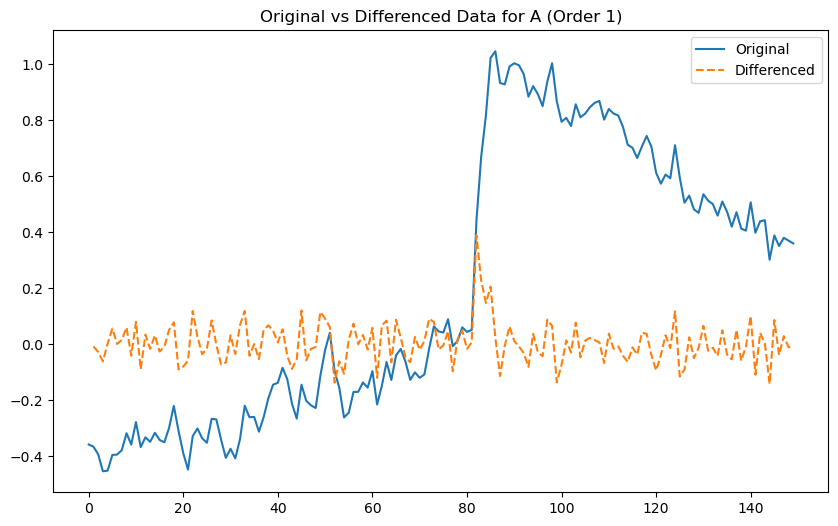

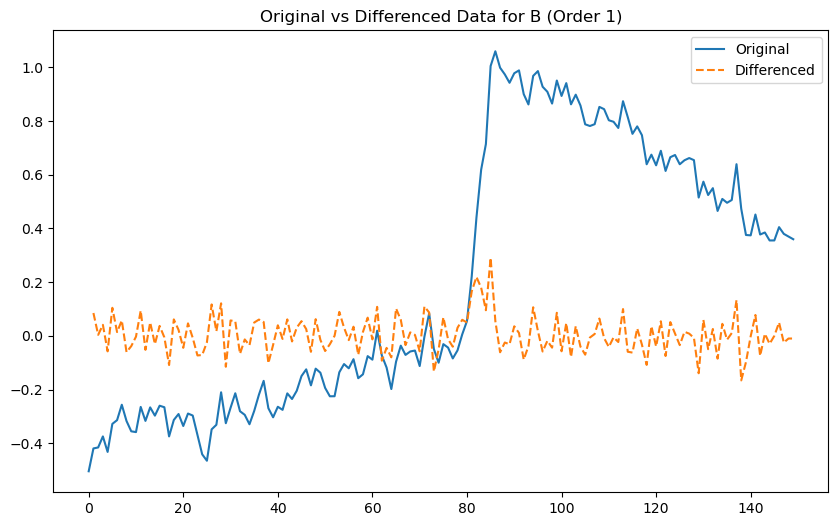

Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    5.852               0.000                8                True
B => A    6.784               0.000                5                True



d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


'Granger Causality Test\n------------------------------------------------------------\nDirection                   F-statistics         p-value         lag         Granger cause\nA => B    5.852               0.000                8                True\nB => A    6.784               0.000                5                True\n'

In [17]:
from toolbox import GC_functions as GC
import importlib
importlib.reload(GC)

dummy_warming_lagged_checked = GC.make_stationary(data,['A', 'B'], test_method='ADF', plot=True)
GC.gc_test(data, 'A','B', max_lags=10)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors

def causal_matshow_ax(causal_results, ax, title='Causal Results',ylabel='Causal Strength'):
    cmap = ListedColormap(['white', 'green'])  # white for low confidence, green for high confidence
    bounds = [-0.5, 0.5, 1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    cax = ax.matshow(causal_results, interpolation='nearest', cmap=cmap, norm=norm)
    plt.colorbar(cax, ax=ax, ticks=[0, 1], shrink=0.6)
    lags = np.arange(causal_results.shape[1])  # Assuming lags increase by 1
    causal_strengths = np.linspace(0.1, 1.0, causal_results.shape[0])  # Assuming linear space for causal strengths
    # add grid lines
    ax.grid(linestyle='--', linewidth=0.5)
    
    ax.set_xticks(np.arange(len(lags)))
    ax.set_xticklabels(lags)
    ax.set_yticks(np.arange(len(causal_strengths)))
    ax.set_yticklabels(np.round(causal_strengths, 1))
    ax.set_xlabel('Lags (yr)')
    ax.set_ylabel(ylabel)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(title)
    # set the xticklabel to be xticks*10
    ax.set_xticklabels([str(int(i*10)) for i in ax.get_xticks()])
    # set the linewidth of the box spine
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)



In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize parameters
beta = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10
iterations = 100
causal_AB_results = np.zeros((len(beta), len(lags)))
causal_BA_results = np.zeros((len(beta), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(beta):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            # print (f'beta: {beta}, lag: {-lag}')
            data = gen_bi_directional_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=strength, sigma=0.05)
            # dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, sigma=0.06633234778696487, tau=13.649751415738818)
            # dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=13.649751415738818, sigma=0.06633234778696487)
            
            df_gc = data[['A', 'B']]
            
            df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
            gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
            causal_AB = gc_results_A_B[0]['XY']
            causal_BA = gc_results_A_B[0]['YX']
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95






d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

In [38]:
causal_results_red_nozscore = np.where((causal_AB_results == 1) & (causal_BA_results == 1), 1, 0)

In [42]:
# save the results to D:\VScode\Paleoclimate_causality\syth_test_results
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_AB_results_twoways_GC.npy', causal_AB_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_BA_results_twoways_GC.npy', causal_BA_results)
np.save('D:\\VScode\\Paleoclimate_causality\\syth_test_results\\causal_results_red_nozscore_twoways_GC.npy', causal_results_red_nozscore)

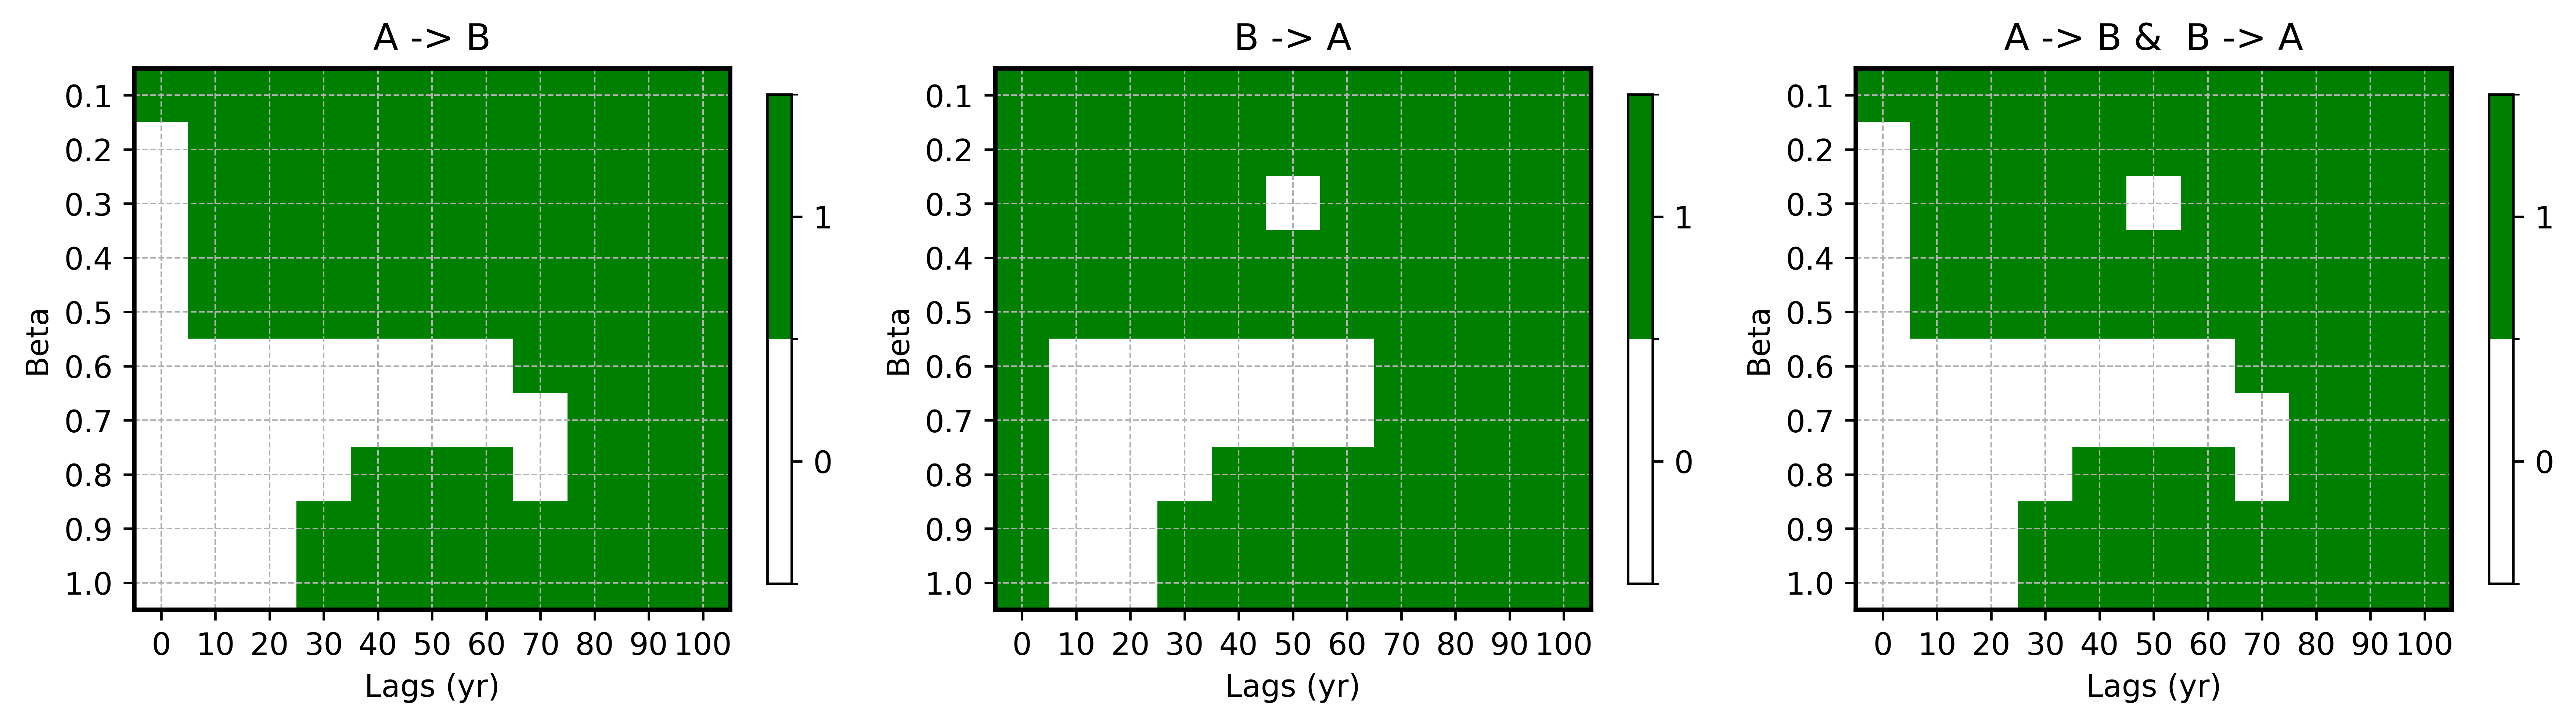

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
causal_matshow_ax(causal_AB_results, axs[0], title='A -> B', ylabel='Beta')
causal_matshow_ax(causal_BA_results, axs[1], title='B -> A', ylabel='Beta')

# Assuming causal_results_red_nozscore is derived in your existing code
causal_matshow_ax(causal_results_red_nozscore, axs[2], title='A -> B &  B -> A', ylabel='Beta')

plt.tight_layout()
plt.show()